In [1]:
from simpleai.search import SearchProblem, depth_first, breadth_first, uniform_cost, greedy, astar
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np

In [7]:
class Space:
    def __init__(self, name, demand, area, x, y, delivered=0):
        self.name = name
        self.demand = demand
        self.delivered = delivered
        self.x = x
        self.y = y
        self.area = area

    def __str__(self):
        return f"{self.name} - {self.demand}"

In [ ]:
class Camion:
    def __init__(self, max_capacity, location, shift_duration):
        self.max_capacity = max_capacity
        self.current_capacity = max_capacity

        self.location = location
        self.routes = []
        self.current_route = []
        
        self.shift_duration = shift_duration
        self.hours = 0

        self.shift_count = 0

In [2]:
class TSP(SearchProblem):
    def init(self, camion, environment):
        self.camion = camion
        self.environment = environment
        self.initial_state = [camion.location, False]
        SearchProblem.__init__(self, self.initial_state)
        self.goal_state = [environment[17], True]

    def actions(self, current_state, environment):
        actions = []
        for space in environment:
            if space not in current_state:
                actions.append(space)
        return actions
    
    def result(self, current_state, action):
        current_edge = [current_state[0].name, action]
        
        if action.name == "P18":
            self.camion.current_capacity = self.camion.max_capacity
            self.camion.current_route.append(current_edge)
            self.camion.routes.append(self.camion.current_route)
            self.camion.current_route = []
        else:
            if self.camion.current_capacity >= action.demand - action.delivered:
                # Se puede entregar toda la demanda
                self.camion.current_capacity -= action.demand - action.delivered
                action.delivered = action.demand
            else:
                # No se puede entregar toda la demanda
                action.delivered += self.camion.current_capacity
                self.camion.current_capacity = 0
            
            self.camion.current_route.append(current_edge)

        return [action, all(space.delivered == space.demand for space in self.environment)]
    
    def is_goal(self,state):
        return state == self.goal_state
    
    def cost(self,state1,action,state2):
        distance = (state1[0].x - state2[0].x)**2 + (state1[0].y - state2[0].y)**2
        time = distance / 10 # 10 km/h
        time += 0.5 # Se debe quedar 30 minutos en cada punto.

        return time
        

In [8]:
# Camion
class Agent():
    def __init__(self, max_capacity, location, shift_duration):
        self.max_capacity = max_capacity
        self.current_capacity = max_capacity

        self.location = location
        self.routes = []
        self.current_route = []
        
        self.shift_duration = shift_duration
        self.hours = 0

    def __str__(self):
        return f"{self.max_capacity} - {self.current_capacity} - {self.location} - {self.shift_duration} - {self.hours}"
    
    def move(self, new_location):
        current_edge = [self.location.name, new_location.name]
        self.location = new_location
        
        if new_location.name == "P18":
            self.current_capacity = self.max_capacity
            self.current_route.append(current_edge)
            self.routes.append(self.current_route)
            self.current_route = []
        else:
            if self.current_capacity >= new_location.demand - new_location.delivered:
                # Se puede entregar toda la demanda
                self.current_capacity -= new_location.demand - new_location.delivered
                new_location.delivered = new_location.demand
            else:
                # No se puede entregar toda la demanda
                new_location.delivered += self.current_capacity
                self.current_capacity = 0
            
            self.current_route.append(current_edge)
    
    def next(self, environment):
        # Hay lugares por visitar
        # Espacios de busqueda
        search_space = [space for space in environment if ((space != self.location) and (space.demand != space.delivered) and (space.name != "P18"))]
        
        if self.current_capacity == 0:
            # Regreso a HQ
            self.move(environment[17])
            # print("Regresando a HQ")
        else:
            if search_space:

                # HEURISTICA 2: Escoge el espacio más cercano (GREEDY)
                next_space = min(search_space, key=lambda space: (space.x - self.location.x)**2 + (space.y - self.location.y)**2)

                self.move(next_space)

                # print(f"Next: {next_space.name}")
            # Actualizacion de estado
            else:
                print("Todos los nodos han sido visitados.")
                return

    def view_state(self):
        space = self.location
        print(f"Location: {space.name}")
        print(f"Delivered: {space.delivered}/{space.demand}")
        print(f"Current Capacity: {self.current_capacity}")
        print("-------------------------")

    def view_graph(self, environment):
        dim = int(np.ceil(np.sqrt(len(self.routes))))
        fig = plt.figure(figsize=(15,15))
        fig.suptitle("Routes", fontsize=16)  # Title for the entire figure

        nodes = [space.name for space in environment]
        pos = {space.name: (space.x, space.y) for space in environment}

        for i, route in enumerate(self.routes):
            print(i,route)
            ax = fig.add_subplot(dim, dim, i+1)
            ax.set_title(f"Route {i+1}")  # Title for each subplot
            # ax.text(0.5, -0.1, route, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

            G = nx.DiGraph()
            G.add_nodes_from([space.name for space in environment])
            G.add_edges_from(route)
            nx.draw_networkx(G, pos=pos, ax=ax)

        plt.tight_layout()
        plt.show()

    def search(self, environment):
        # Goal state: All spaces have demand = delivered
        while any([space.demand != space.delivered for space in environment]) and (self.hours <= self.shift_duration):
            self.next(environment)
            # print([space.demand != space.delivered for space in environment])

        if self.location != environment[17]:
            self.move(environment[17])
        # Goal state reached
        print("All spaces have been visited.")
        self.view_graph(environment)

In [9]:
space_data = {
    # "name" : (x, y, area)
    "P1": (-56, -1298, 5.4),
    "P2": (-602, -1030, 7.52),
    "P3": (-394, -1042, 8),
    "P4": (-195, -1046, 8),
    "P5": (1, -1046, 7.56),
    "P6": (-814, -932, 4.19),
    "P7": (-824, -643, 6.28),
    "P8": (-600, -600, 7.6),
    "P9": (-399, -639, 8),
    "P10": (-195, -632, 8),
    "P11": (0, -600, 7.67),
    "P12": (56, -334, 5.4),
    "P13": (-195, -258, 5.98),
    "P14": (-417, -269, 7.34),
    "P15": (-794, -258, 7.97),
    "P16": (408, -158, 5.64),
    "P17": (189, -43, 6.11),
    "P18": (0, 0, 7.11), # <--------------------------------------- HQ
    "P19": (600, 0, 4.92),
    "P20": (-931, 75, 1.38),
    "P21": (-808, 75, 8),
    "P22": (-604, 79, 7.82),
    "P23": (-403, 136, 5.53),
    "P24": (-206, 133, 5.64),
    "P25": (800, 200, 5.05),
    "P26": (1000, 400, 4.75),
    "P27": (-927, 445, 1.28),
    "P28": (-801, 434, 6.64),
    "P29": (-597, 431, 6.54),
    "P30": (-349, 380, 6.76),
    "P31": (153, -492, 1.47),
}

New agent
All spaces have been visited.
0 [['P18', 'P17'], ['P17', 'P16'], ['P16', 'P19'], ['P19', 'P25'], ['P25', 'P26'], ['P26', 'P12'], ['P12', 'P31'], ['P31', 'P11'], ['P11', 'P10'], ['P10', 'P18']]
1 [['P18', 'P24'], ['P24', 'P23'], ['P23', 'P22'], ['P22', 'P21'], ['P21', 'P20'], ['P20', 'P15'], ['P15', 'P14'], ['P14', 'P13'], ['P13', 'P10'], ['P10', 'P18']]
2 [['P18', 'P30'], ['P30', 'P29'], ['P29', 'P28'], ['P28', 'P27'], ['P27', 'P7'], ['P7', 'P8'], ['P8', 'P9'], ['P9', 'P3'], ['P3', 'P4'], ['P4', 'P18']]
3 [['P18', 'P5'], ['P5', 'P4'], ['P4', 'P1'], ['P1', 'P2'], ['P2', 'P6'], ['P6', 'P18']]


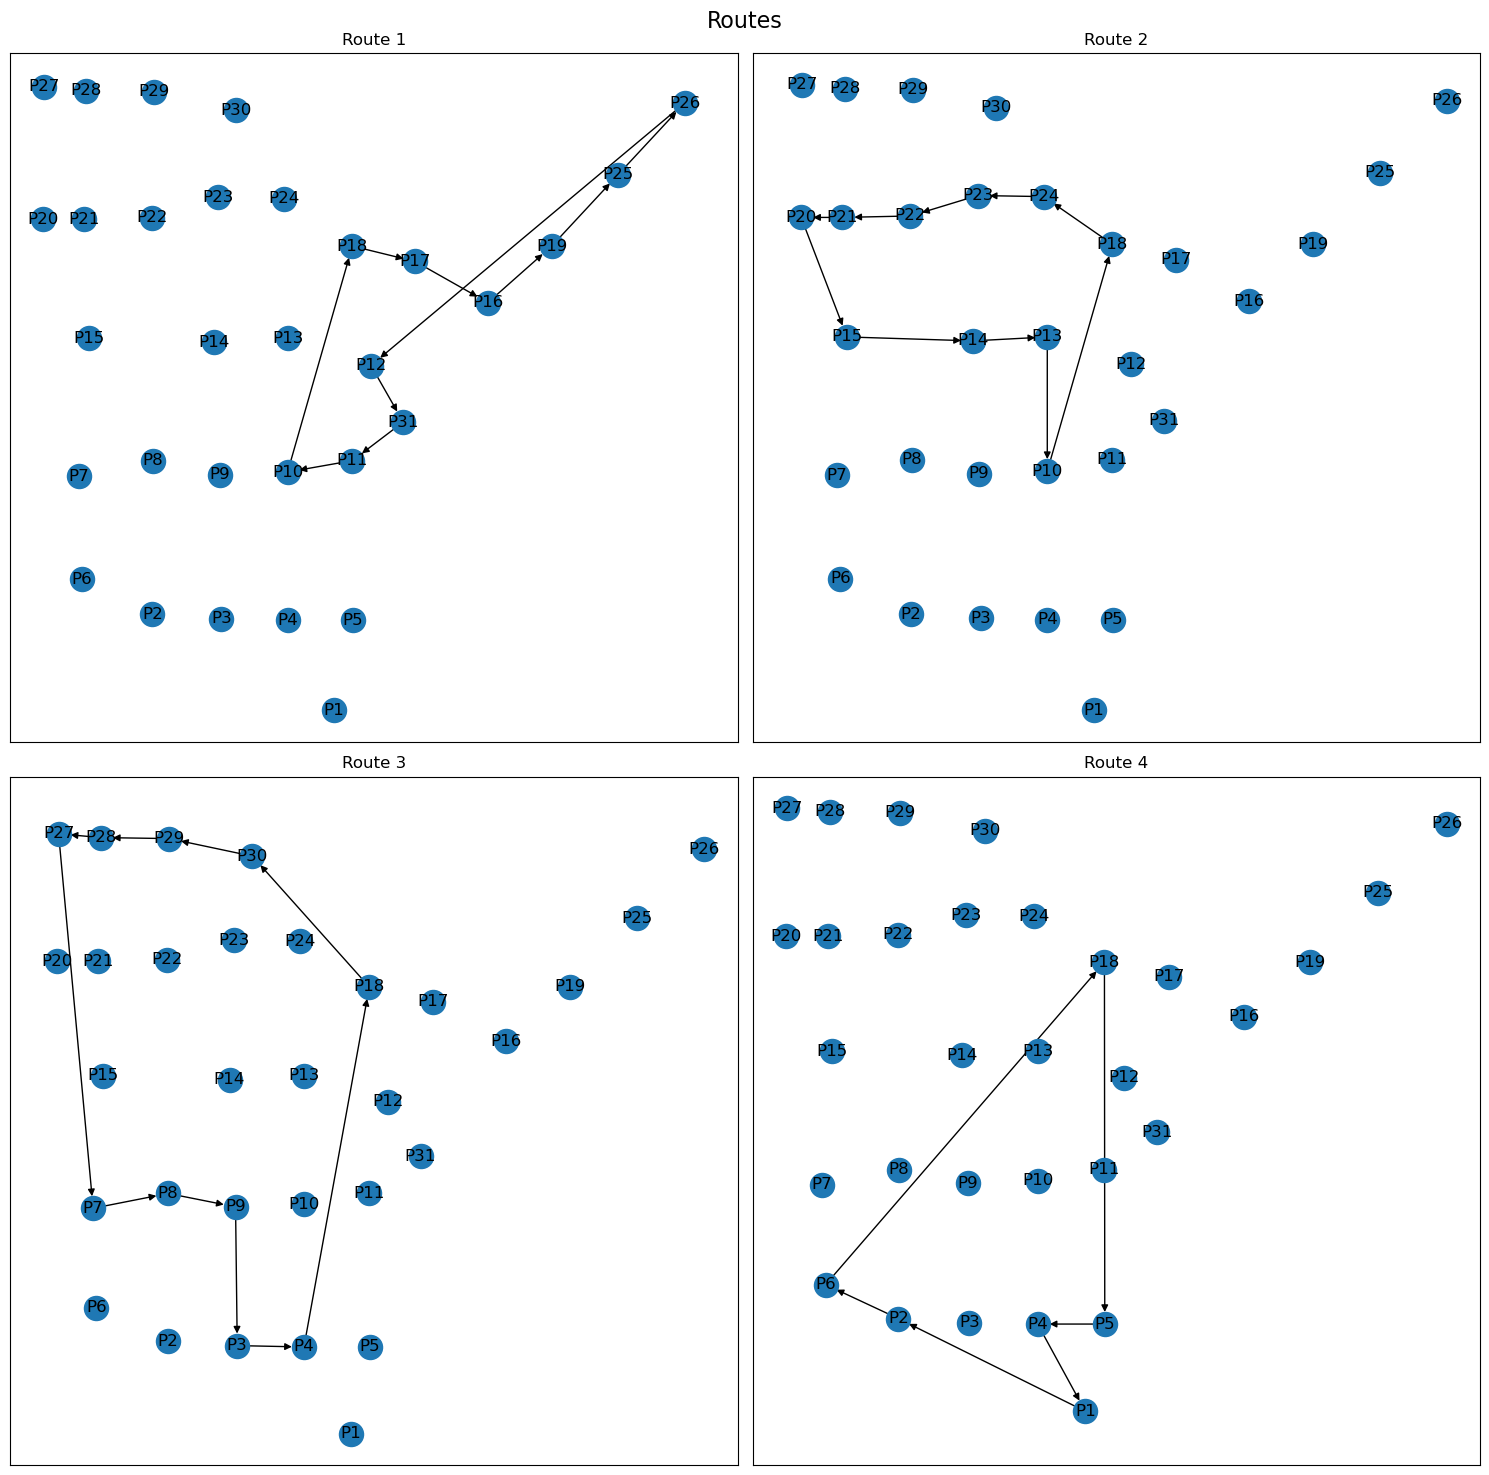

In [10]:
# No podemos asumir que todos los espacios tienen la misma demanda
# Pero podemos asumir que la demanda de cada espacio es un valor fijo por ahora

spaces = [Space(name=key, demand=10, x=value[0], y=value[1], area=value[2]) for key, value in space_data.items()]
spaces[17].demand = 0

agents = []
# Agent

while any([space.demand != space.delivered for space in spaces]):
    print("New agent")
    temp = Agent(max_capacity=85, location=spaces[17], shift_duration=8)
    temp.search(spaces)
    agents.append(temp)